# Clustering cities depending on their most common features

## 1. Imports and such things

Use pandas to handle dataframes

In [1]:
import pandas as pd

Use Scikit-learn to do clustering

In [18]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics

Use matplotlib to create a graph to find optimal k

In [3]:
import matplotlib.pyplot as plt

## 2. Import dataframes from notebook 1

This dataframe contains Cities, with their nation, population, Wikipedia URL, Latitude and Longitude

In [4]:
df_cities = pd.read_pickle('cities.pickle')
df_cities.head()

,City,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,Aa en Hunze,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,53.000000,6.750000
1,Aalburg,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,51.752500,5.131944
2,Aalsmeer,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,https://nl.wikipedia.org/wiki/Bestand:Aalsmeer...,52.263889,4.762500
3,Aalten (gemeente),Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,51.925000,6.580833
4,Achtkarspelen,Friesland,27897,102.61,272.7,11400,https://nl.wikipedia.org/wiki/Achtkarspelen,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,53.216667,6.133333


In [5]:
df_cities.describe()

,Area,Density,Latitude,Longitude
count,377.000000,377.000000,377.000000,377.000000
mean,86.195942,830.626737,51.791472,4.848279
std,78.487682,994.822246,3.291926,6.299450
min,7.110000,22.700000,12.185278,-68.261944
25%,31.720000,226.500000,51.662761,4.776667
50%,63.830000,430.000000,52.026111,5.389722
75%,109.590000,1051.700000,52.400000,5.977500
max,578.000000,6231.300000,53.489167,7.084808


This dataframe contains a long list of the top pick venues according to Foursquare in those cities 

In [6]:
df_venues = pd.read_pickle('venues.pickle')
df_venues.head()

,City,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Aa en Hunze,Hof van Saksen,4be09a4f4c55b651217beab7,52.966395,6.674498,Resort
1,Aa en Hunze,Robin Hood Ribhouse,4b85585df964a5200b5831e3,52.957088,6.788140,Restaurant
2,Aa en Hunze,Zwembad | Hof van Saksen,4c3b2cb3d94dc9b63156ffe7,52.965237,6.676055,Pool
3,Aa en Hunze,Restaurant Hofsteenge,4bebf67ba9900f47505b1840,52.935398,6.672966,Café
4,Aa en Hunze,Hunebedcentrum,4c2f2541ac0ab71368b41b1e,52.931130,6.797330,History Museum


This dataframe contains a left join of the previous two

In [7]:
df_joined = pd.read_pickle('joined.pickle')
df_joined.head()

,City,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,Aa en Hunze,Hof van Saksen,4be09a4f4c55b651217beab7,52.966395,6.674498,Resort,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,53.0,6.75
1,Aa en Hunze,Robin Hood Ribhouse,4b85585df964a5200b5831e3,52.957088,6.788140,Restaurant,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,53.0,6.75
2,Aa en Hunze,Zwembad | Hof van Saksen,4c3b2cb3d94dc9b63156ffe7,52.965237,6.676055,Pool,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,53.0,6.75
3,Aa en Hunze,Restaurant Hofsteenge,4bebf67ba9900f47505b1840,52.935398,6.672966,Café,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,53.0,6.75
4,Aa en Hunze,Hunebedcentrum,4c2f2541ac0ab71368b41b1e,52.931130,6.797330,History Museum,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,53.0,6.75


## 3. Counting venues categories

Just as in the lectures, we want to find out what the most recommended types of venues are for each city.

We do this by first turning the venue categories in one-hot notations, and then averaging these numbers for every city.
This automatically takes care of having different amounts of venues for different cities.


In [44]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add city and nation columns back to the dataframe
df_venues_onehot['City'] = df_venues['City']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

df_venues_onehot.head()

,City,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Apres Ski Bar,Argentinian Restaurant,Art Gallery,Art Museum,...,Volleyball Court,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aa en Hunze,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Most common venue categories per city

We can now group by city

In [57]:
df_venues_grouped = df_venues_onehot.groupby(['City']).sum().reset_index()

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 5

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    columns.append('Common Venue {}'.format(ind+1))

# create a new dataframe
df_common_venues = pd.DataFrame(columns=columns)
df_common_venues['City'] = df_venues_grouped['City']

# actually perform counting
for ind in np.arange(df_venues_grouped.shape[0]):
    df_common_venues.iloc[ind, 1:] = return_most_common_venues(df_venues_grouped.iloc[ind, :], num_top_venues)

In [60]:
df_common_venues.head()

,City,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5
0,'s-Hertogenbosch (gemeente),Bar,Café,Restaurant,Coffee Shop,Mediterranean Restaurant
1,Aa en Hunze,Restaurant,Resort,Park,Diner,Hotel
2,Aalburg,Restaurant,Diner,Supermarket,Ice Cream Shop,Café
3,Aalsmeer,Harbor / Marina,Gym / Fitness Center,Supermarket,Restaurant,Athletics & Sports
4,Aalten (gemeente),Campground,Supermarket,Ice Cream Shop,Restaurant,Gym


## 5. Finding similar cities

For clustering, we use the averages for every category as found in section 3, but drop the city/nation attributes

Maybe we also want to include population, density.

We do not have too many NaNs in the Income table to make it useful.

In [61]:
#df_clustering = pd.merge(df_venues_grouped, df_cities2[['City', 'Population', 'Density']], on='City').drop(['City'], 1)
df_clustering = df_venues_grouped.drop(['City'],1)
df_clustering.head()

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Apres Ski Bar,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Volleyball Court,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,1,0,3,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### 4.1 Finding optimal value for k

We look at a silhouette score for various values of k to find an optimal one.

A first look immediately finds that 2,3,4 give better values, but I find that too few clusters.

maximum is 0.1650037992524023, which occurs at k=2


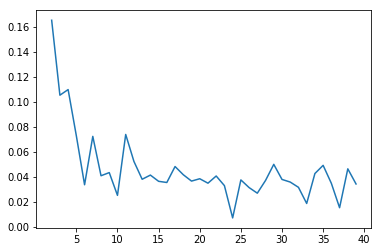

In [62]:
START = 2
END = 40
scores = []
for k in range(START, END):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k).fit(df_clustering)
    
    scores.append(metrics.silhouette_score(df_clustering, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
plt.plot(range(START,END),scores)
kclusters=np.argmax(scores)+START

### 4.2 Clustering

We continue with $k=5$

In [66]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(df_clustering)

In [67]:
df_common_venues['Cluster label'] = kmeans.labels_

df_cities2 = pd.merge(df_common_venues, df_cities, how='left',
        on=['City'], validate="1:1")
df_cities2.head()

,City,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Cluster label,Province,Population,Area,Density,Income,URL,FlagURL,Latitude,Longitude
0,'s-Hertogenbosch (gemeente),Bar,Café,Restaurant,Coffee Shop,Mediterranean Restaurant,0,Noord-Brabant,153434,84.63,1783.7,13900,https://nl.wikipedia.org/wiki/%27s-Hertogenbos...,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,51.689167,5.303056
1,Aa en Hunze,Restaurant,Resort,Park,Diner,Hotel,3,Drenthe,25319,276.35,91.2,13400,https://nl.wikipedia.org/wiki/Aa_en_Hunze,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,53.000000,6.750000
2,Aalburg,Restaurant,Diner,Supermarket,Ice Cream Shop,Café,2,Noord-Brabant,13191,50.40,257.5,12500,https://nl.wikipedia.org/wiki/Aalburg,https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,51.752500,5.131944
3,Aalsmeer,Harbor / Marina,Gym / Fitness Center,Supermarket,Restaurant,Athletics & Sports,4,Noord-Holland,31584,20.58,1512.7,14700,https://nl.wikipedia.org/wiki/Aalsmeer,https://nl.wikipedia.org/wiki/Bestand:Aalsmeer...,52.263889,4.762500
4,Aalten (gemeente),Campground,Supermarket,Ice Cream Shop,Restaurant,Gym,3,Gelderland,26943,96.57,278.7,11900,https://nl.wikipedia.org/wiki/Aalten_(gemeente),https://nl.wikipedia.org/wiki/Bestand:Flag_of_...,51.925000,6.580833


## 5. Export the results

In [68]:
df_cities2.to_csv('cities2.csv')
df_cities2.to_pickle('cities2.pickle')